### Set-up

In [1]:
# prevent autoscroll in Colab when working in multiple tabs
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

SyntaxError: invalid syntax (3375358065.py, line 3)

In [2]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-nolp6ka7
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-nolp6ka7
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import os
import random
from time import time
import pandas as pd
import numpy as np # for numerical operations, super useful for dealing with arrays/matrices
from tqdm.notebook import tqdm
import pickle # for storing information into pickle files

# for visualization
from plotly import graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# for the scores and confusion matrices
from sklearn.metrics import fbeta_score, confusion_matrix

# for visualization
from matplotlib import pyplot as plt
%matplotlib inline

import cv2

# PyTorch imports: useful for anything to do with our model
# (i.e., the model itself, loading the data into the model, etc,)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
!pip install -q torchsummary --user
from torchsummary import summary


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


### Load CLIP

In [4]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_encoder, preprocess = clip.load('ViT-B/32', device)

In [5]:
# # Calculate features
# with torch.no_grad(): # was I supposed to do this...
#     image_features = model.encode_image(image_input) # image_input is of dims (batch, num channels, height, width) and the features are of size (batch, 512)

### ADE20K Data

In [8]:
# from google.colab import drive

# # This will prompt you to click on a link and get an authorization code
# drive.mount('/content/drive', force_remount=True)

# %ls
# %cd '/drive/MyDrive/514 Project'
# !sh download_and_convert_ade20k.sh
# %cd /content/drive/MyDrive/514 Project/ADE20K/ADEChallengeData2016/
%cd /scratch/gpfs/ryzhu/cos514/ADE20K/ADEChallengeData2016/

/scratch/gpfs/ryzhu/cos514/ADE20K/ADEChallengeData2016


/home/ryzhu/.pyenv/versions/3.10.12/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [9]:
import os

# checking how much training and validation data we have
train_paths = ["images/training", ]
val_paths = ["images/validation", ]
# num_train = sum("_train_" in s for s in df_classes['filename'].tolist())
# num_val = sum("_val_" in s for s in df_classes['filename'].tolist())
# print(
#     f"train files: {num_train}, "
#     f"validation files: {num_val}"
# )

8809
           image_name              tags           list_tags
0  ADE_train_00000001  airport_terminal  [airport_terminal]
1  ADE_train_00000002  airport_terminal  [airport_terminal]
5  ADE_train_00000006          bathroom          [bathroom]
6  ADE_train_00000007          bathroom          [bathroom]
7  ADE_train_00000008          bathroom          [bathroom]


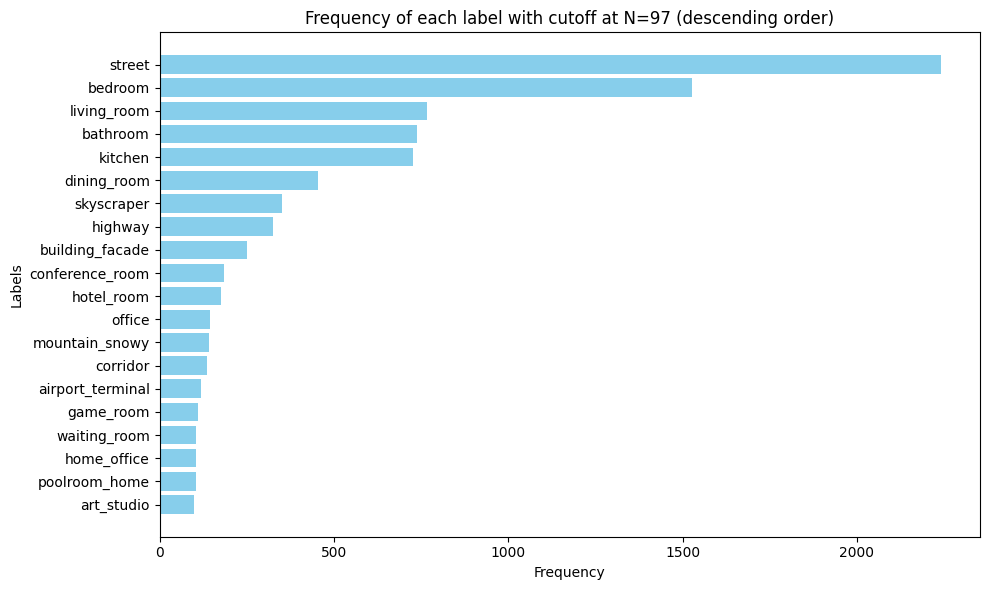

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the text file into a DataFrame
df_classes = pd.read_csv('sceneCategories.txt', sep=' ', header=None, names=['filename', 'label'])

# Count the frequency of each label
label_counts = df_classes['label'].value_counts()

# Exclude the label "misc"
label_counts = label_counts[label_counts.index != 'misc']

# Apply a cutoff to include only labels with frequencies above 97
cutoff = 97
filtered_label_counts = label_counts[label_counts > cutoff]
df_classes = df_classes[df_classes['label'].isin(filtered_label_counts.keys())]

# Sort labels based on frequency in descending order
sorted_labels = filtered_label_counts.sort_values().index

# for loss calculation function. Take anything that occurs less than 1/10th the most common frequency
rare_label_counts = filtered_label_counts[filtered_label_counts < filtered_label_counts.iloc[0]/10]
RARE_CLASSES = rare_label_counts.index.tolist()

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_labels, label_counts[sorted_labels], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Labels')
plt.title('Frequency of each label with cutoff at N=97 (descending order)')
plt.tight_layout()

print(df_classes.shape[0])
df_classes = df_classes.rename(columns={"filename": "image_name",  "label": "tags"})
df_classes["list_tags"] = df_classes.tags.str.split(" ")
print(df_classes.head())

# Show the plot
plt.show()


In [11]:
# another helper function for loading data information
def load_split(paths, df_class):
    if isinstance(paths, str):
        paths = [paths]
    elif not isinstance(paths, (list, tuple, set)):
        raise ValueError('Expected type in {list, tuple, set, str} but got ' + str(type(paths)))
    image_names = list()
    for path in paths:
        image_names += list(map(lambda x: x.split('.', 1)[0], os.listdir(path)))
    return df_class[df_class.image_name.map(lambda x: x in image_names)].reset_index(drop=True)

In [12]:
from torch.utils.data import DataLoader, Dataset
import cv2
import matplotlib.pyplot as plt
from PIL import Image

class ADE20kDataset(Dataset):
    # basically defines what information we store for a dataset
    def __init__(
        self,
        df,
        transform,
        paths,
        is_train=True,
        idx_tta=None,
    ):
        super().__init__()
        self.df = df
        self.ohe_tags = list(map(transform_targets, self.df.list_tags.values))
        self.transform = transform
        if isinstance(paths, str):
            self.paths = [paths]
        elif isinstance(paths, (list, tuple)):
            self.paths = paths
        else:
            raise ValueError('expected path to be a string or list or tuple')
        self.is_train = is_train
        if not is_train:
            if not idx_tta in list(range(6)):
                raise ValueError(
                    f"In test mode, 'idx_tta' must be an int belonging to [0, 5], got: {repr(idx_tta)}"
                )
            self.idx_tta = idx_tta

    # returns how many examples are in the data
    def __len__(self):
        return len(self.df)

    # get the example corresponding to the parameter idx from the dataset
    def __getitem__(self, idx):
        filename = self.df.iloc[idx].image_name + ".jpg"
        files = list()
        for path in self.paths:
            file_path = os.path.join(path, filename)
            if os.path.isfile(file_path):
                files.append(file_path)
        if len(files) == 0:
            raise FileNotFoundError(filename + ' not found in ' + ' '.join(self.paths))
        elif len(files) > 1:
            raise ValueError(f'Found {len(files)} values for {filename} as {files}')
        else:
            file_path = files[0]
        img = cv2.imread(file_path)
        if img is None:
            raise ValueError('Problem reading image from %s' % file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.ohe_tags[idx]
        return img, label

    # returns images and labels in a batch with augmentations applied
    def collate_fn(self, batch):
        imgs, labels = [], []
        for (img, label) in batch:
            img = Image.fromarray(img)
            # img = self.custom_augment(img)
            # img = torch.tensor(img)
            # img = img.permute(2, 0, 1)
            # img = self.transform(img) # looks like it's already taken care of with the preprocess transforms from clip
            image_input = preprocess(img).unsqueeze(0).to(device)
            with torch.no_grad():
              img_embed = clip_encoder.encode_image(image_input)
            imgs.append(img_embed)
            labels.append(label)
        imgs = torch.cat(imgs).float().to(device)
        labels = torch.tensor(labels).float().to(device)
        return imgs, labels

    # loads and displays the example corresponding to the parameter idx
    def load_img(self, idx, ax=None):
        img, ohe_label = self[idx]
        label = self.df.iloc[idx].tags
        title = f"{label} - {ohe_label}"
        if ax is None:
            plt.imshow(img)
            plt.title(title)
        else:
            ax.imshow(img)
            ax.set_title(title)

    # applies data augmentations to the parameter img, not used so far
    def custom_augment(self, img):
        """
        If we want data augmentations
        """
        return img

In [13]:
def get_transforms():
    transform_train = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
          mean=[0.485, 0.456, 0.406],  # Set by previously known values
          std=[0.229, 0.224, 0.225],   # Set by previously known values
      )
    ])
    transform_val = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
        mean=[0.485, 0.456, 0.406],  # Set by previously known values
        std=[0.229, 0.224, 0.225],   # Set by previously known values
      )
    ])
    return transform_train, transform_val

In [14]:
# the possible labels for our dataset
INVERSE_LABEL_IDXS = dict(enumerate(df_classes['tags'].unique()))

LABEL_IDXS = {v: k for k, v in INVERSE_LABEL_IDXS.items()}

# converts the parameter tag_list (list of words, subset of the keys in LABEL_IDXS) to a one-hot encoding
def transform_targets(tag_list):
    targets = np.zeros(len(LABEL_IDXS), dtype=np.int8)
    mask = [LABEL_IDXS[tag] for tag in tag_list]
    targets[mask] = 1
    # returns list of ones and zeros
    # (e.g. tag_list = ['primary', 'haze'] -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
    return targets.tolist()

# converts the parameter targets (one-hot encoding) back into a list of tags (subset of words from LABEL_IDXS)
def inverse_transform_targets(targets):
    idxs = [idx for idx, target in enumerate(targets) if target]
    tag_list = [INVERSE_LABEL_IDXS[ix] for ix in idxs]
    return list(sorted(tag_list))

In [15]:
print(LABEL_IDXS)

{'airport_terminal': 0, 'bathroom': 1, 'bedroom': 2, 'conference_room': 3, 'corridor': 4, 'kitchen': 5, 'living_room': 6, 'mountain_snowy': 7, 'office': 8, 'poolroom_home': 9, 'skyscraper': 10, 'art_studio': 11, 'building_facade': 12, 'dining_room': 13, 'game_room': 14, 'highway': 15, 'home_office': 16, 'hotel_room': 17, 'street': 18, 'waiting_room': 19}


In [16]:
df_train = load_split(train_paths, df_classes)
df_val = load_split(val_paths, df_classes)

In [17]:
transform_train, transform_val = get_transforms()
ds_train = ADE20kDataset(df_train, transform_train, paths=train_paths)
ds_val = ADE20kDataset(df_val, transform_val, paths=val_paths)

In [18]:
# import matplotlib.pyplot as plt

# # Read the contents of the text file
# with open('sceneCategories.txt', 'r') as file:
#     lines = file.readlines()

# # Extract labels from each line
# fns, labels = [], []
# for line in lines:
#   e = line.split()
#   fns.append(e[0]), labels.append(e[1])


# # Count the frequency of each label
# label_counts = {}
# for label in list(set(labels)):
#   if labels.count(label) > 97 and label != "misc":
#     label_counts[label] = labels.count(label)

# sorted_labels = sorted(label_counts.keys(), key=lambda x: label_counts[x])
# print(len(sorted_labels))

# # Create a bar plot
# plt.figure(figsize=(10, 6))
# plt.barh(sorted_labels, [label_counts[label] for label in sorted_labels], color='skyblue')
# plt.xlabel('Frequency')
# plt.ylabel('Labels')
# plt.title('Frequency of each label with cutoff at N=97 (descending order)')
# plt.tight_layout()

# # Show the plot
# plt.show()


### Training

In [19]:
from torchvision import transforms as T, models
import torch.nn as nn

def get_model(weights=False, dropout_rate=0.2):
    model = nn.Sequential(
      nn.Linear(512, 128),
      nn.ReLU(inplace=True),
      nn.Dropout(dropout_rate),
      ######### FILL IN HERE #########
      nn.Linear(128, 20),
      ######### END #########
      nn.Sigmoid()
    )

    return model.to(device)

In [20]:
def train_batch(X, Y, model, loss_fn, optimizer):
    model.train()
    ######### FILL IN HERE #########
    optimizer.zero_grad()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    batch_loss.backward()
    optimizer.step()
    ######### END #########
    Y_hat = Y_hat.detach().float().cpu().numpy()  # detach predictions from gradients for logging

    return Y_hat, batch_loss.item()

In [21]:
@torch.no_grad()
def compute_val_loss(X, Y, model, loss_fn):
    model.eval()
    ######### FILL IN HERE #########
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    ######### END #########
    Y_hat = Y_hat.float().cpu().numpy()

    return Y_hat, batch_loss.item()

In [31]:
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import fbeta_score, confusion_matrix

def train_model(model, optimizer, loss_fn, dl_train, dl_val, epochs, filename, loss_scale=1):
    lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    loss_train, loss_val = [], []
    score_train, score_val = [], []

    Y_hat_val = None
    best_loss_val = np.inf

    for idx in range(epochs):
        loss_train_epoch, loss_val_epoch = [], []
        Y_hat_train_epoch, Y_hat_val_epoch = [], []
        Y_train_epoch, Y_val_epoch = [], []

        for X, Y in tqdm(dl_train, leave=False):
            Y_hat, batch_loss = train_batch(X, Y, model, loss_fn, optimizer)
            loss_train_epoch.append(batch_loss)
            Y_hat_train_epoch.extend(Y_hat)
            Y_train_epoch.extend(Y.detach().float().cpu().numpy())

        for X, Y in tqdm(dl_val, leave=False):
            Y_hat, batch_loss = compute_val_loss(X, Y, model, loss_fn)
            loss_val_epoch.append(batch_loss)
            Y_hat_val_epoch.extend(Y_hat)
            Y_val_epoch.extend(Y.detach().float().cpu().numpy())

        avg_loss_train = np.mean(loss_train_epoch)
        avg_loss_val = np.mean(loss_val_epoch)

        Y_hat_train_epoch = np.array(Y_hat_train_epoch)
        Y_hat_val_epoch = np.array(Y_hat_val_epoch)
        Y_thresh_train_epoch = (Y_hat_train_epoch > .2).astype(float)
        Y_thresh_val_epoch = (Y_hat_val_epoch > .2).astype(float)
        Y_train_epoch = np.array(Y_train_epoch)
        Y_val_epoch = np.array(Y_val_epoch)

        score_train_epoch = fbeta_score(Y_train_epoch, Y_thresh_train_epoch, beta=2, average="samples")
        score_val_epoch = fbeta_score(Y_val_epoch, Y_thresh_val_epoch, beta=2, average="samples")

        # saving values for debugging
        if avg_loss_val < best_loss_val:
            best_loss_val = avg_loss_val
            Y_hat_val = Y_hat_val_epoch
            Y_thresh_val = Y_thresh_val_epoch
            Y_val = Y_val_epoch

        loss_train.append(avg_loss_train)
        loss_val.append(avg_loss_val)
        score_train.append(score_train_epoch)
        score_val.append(score_val_epoch)

        print(
            f"epoch: {idx}/{epochs} -- train loss: {avg_loss_train}, " \
            f"val loss: {avg_loss_val}" \
            f" -- train fbeta_score: {score_train_epoch}, " \
            f"val fbeta_score: {score_val_epoch}"
        )

        lr_scheduler.step()

    train_results = {
        "loss_train": loss_train,
        "loss_val": loss_val,
        "score_train": score_train,
        "score_val": score_val,
        "Y_hat_val": Y_hat_val,
        "Y_thresh_val": Y_thresh_val,
        "Y_val": Y_val,
    }

    torch.save(model, filename + '.pt')
    pickle.dump(train_results, open(filename+'.results', "wb"))
    print(f'Saved model to {filename}.pt')
    print(f'Saved results to {filename}.results')

In [ ]:
from torch.optim import Adam

# Set hyeprparameters for batch size, epochs, learning rate
BATCH_SIZE = 64
LR = 1e-4
EPOCHS = 10
LOSS_SCALES = [1, 5, 10, 50, 100]


for loss_scale in LOSS_SCALES:
    filename = f'ade20k_clip_loss_reweight_{loss_scale}'

    # Load dataset in DataLoader
    dl_train = DataLoader(
        ds_train,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=ds_train.collate_fn
    )
    dl_val = DataLoader(
        ds_val,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=ds_val.collate_fn
    )
    
    # Initialize model
    ######### FILL IN HERE #########
    # What needs to change to use the pretrained model?
    model = get_model(False)
    ######### END #########
    optimizer = Adam(model.parameters(), lr=LR)
    loss_fn = nn.BCELoss()
    
    # Checkpoint file to save models + results
    # filename = f'/content/drive/MyDrive/pretrained_full_data_resnet18__batch_size={BATCH_SIZE}__lr={LR}__epochs={EPOCHS}'
    # Train
    train_model(
        ######### FILL IN HERE #########
        dl_train=dl_train,
        dl_val=dl_val,
        epochs=EPOCHS,
        model=model,
        optimizer=optimizer,
        loss_fn=loss_fn,
        filename=filename,
        loss_scale=loss_scale
        ######### END #########
        )

  0%|          | 0/126 [00:00<?, ?it/s]

In [ ]:
model = torch.load(filename + '.pt')  # load best model
train_results = pickle.load(open(filename + '.results', "rb"))  # load best model results

In [ ]:
# Track loss and performance over time (for train and val)
loss_train = train_results["loss_train"]
loss_val = train_results["loss_val"]
score_train = train_results["score_train"]
score_val = train_results["score_val"]

fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Fbeta scores"))
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_train))),
        y=loss_train,
        name="loss_train",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_val))),
        y=loss_val,
        name="loss_val",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_train))),
        y=score_train,
        name="score_train",
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_val))),
        y=score_val,
        name="score_val",
    ),
    row=1, col=2
)
fig.show()